In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import pickle
import os
import missingno as msno
import shapely.io
from shapely.geometry import Point, LineString

from lxml import etree
from datetime import time

# Load GTFS data

https://github.com/matsim-org/matsim-libs/tree/master/examples/scenarios/pt-tutorial

In [2]:
gtfs_name = '20241023_130210_Metro_Valencia'

## Shapes

In [3]:
shapes_filename = f'data/redes/metro/{gtfs_name}/shapes.txt'

shapes = pd.read_csv(shapes_filename)
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,1,39.622841,-0.590278,1
1,1,39.614395,-0.595912,2
2,1,39.613392,-0.596234,3
3,1,39.607540,-0.594893,4
4,1,39.598881,-0.583928,5
...,...,...,...,...
895,74,39.452591,-0.353216,4
896,74,39.452446,-0.360125,5
897,74,39.459373,-0.365110,6
898,74,39.463913,-0.369531,7


In [4]:
shapes['geometry'] = shapes.apply(lambda row: Point(row['shape_pt_lon'], row['shape_pt_lat']), axis='columns')
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,geometry
0,1,39.622841,-0.590278,1,POINT (-0.590277791 39.6228408813)
1,1,39.614395,-0.595912,2,POINT (-0.5959117413 39.6143951416)
2,1,39.613392,-0.596234,3,POINT (-0.5962336063 39.6133918762)
3,1,39.607540,-0.594893,4,POINT (-0.5948925018 39.6075401306)
4,1,39.598881,-0.583928,5,POINT (-0.5839277506 39.5988807678)
...,...,...,...,...,...
895,74,39.452591,-0.353216,4,POINT (-0.3532159925 39.4525909424)
896,74,39.452446,-0.360125,5,POINT (-0.3601250052 39.4524459839)
897,74,39.459373,-0.365110,6,POINT (-0.3651100099 39.4593734741)
898,74,39.463913,-0.369531,7,POINT (-0.3695310056 39.4639129639)


<Axes: >

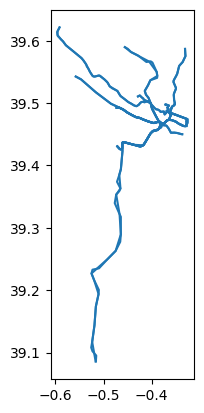

In [6]:
edges.plot()

## Stops

In [7]:
stops_filename = f'data/redes/metro/{gtfs_name}/stops.txt'

stops = pd.read_csv(stops_filename)
stops

,stop_id,stop_name,stop_lat,stop_lon,zone_id
0,30,València Sud,39.440811,-0.410647,A
1,31,Paiporta,39.432262,-0.418061,A B
2,32,Picanya,39.433121,-0.437158,A B
3,33,Torrent,39.434647,-0.460986,A B
4,50,Col·legi El Vedat,39.423134,-0.460653,A B
...,...,...,...,...,...
138,194,Ciutat Arts i Ciències - Justícia,39.452592,-0.353216,A
139,195,Oceanogràfic,39.452038,-0.347342,A
140,196,Moreres,39.450150,-0.338408,A
141,197,Natzaret,39.449889,-0.334674,A


In [8]:
stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis='columns')

<Axes: >

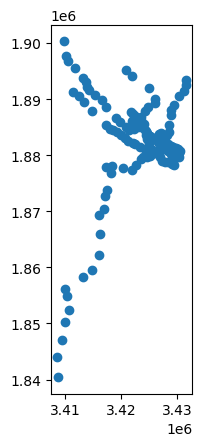

In [9]:
stops = gpd.GeoDataFrame(stops, geometry='geometry', crs='EPSG:4326')
stops = stops.to_crs('EPSG:3035')
stops.plot()

## Routes

In [10]:
routes_filename = f'data/redes/metro/{gtfs_name}/routes.txt'

routes = pd.read_csv(routes_filename)
routes

,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color
0,V1-1-29,1,1,1 - Castelló - Empalme,1,FEC601,FFFFFF
1,V1-1-36,1,1,1 - Castelló - Seminari - CEU,1,FEC601,FFFFFF
2,V1-1-39,1,1,1 - Castelló - Bétera,1,FEC601,FFFFFF
3,V1-13-20,1,1,1 - Picassent - València Sud,1,E60096,FFFFFF
4,V1-13-29,1,1,1 - Picassent - Empalme,1,E60096,FFFFFF
...,...,...,...,...,...,...,...
115,V9-56-73,1,9,9 - Alboraia Peris Aragó - Av. del Cid,1,B7DD79,FFFFFF
116,V9-66-186,1,9,9 - Machado - Riba-roja de Túria,1,B7DD79,FFFFFF
117,V9-66-73,1,9,9 - Machado - Av. del Cid,1,B7DD79,FFFFFF
118,V9-73-56,1,9,9 - Av. del Cid - Alboraia Peris Aragó,1,B7DD79,FFFFFF


## Trips

In [11]:
trips_filename = f'data/redes/metro/{gtfs_name}/trips.txt'

trips = pd.read_csv(trips_filename)
trips

,route_id,service_id,trip_id,trip_headsign,shape_id
0,V10-190-197,2502,4118993,Natzaret,74
1,V10-197-190,2502,4119082,Alacant,73
2,V10-190-197,2502,4118994,Natzaret,74
3,V10-197-190,2502,4119083,Alacant,73
4,V10-190-197,2502,4118995,Natzaret,74
...,...,...,...,...,...
11646,V5-123-69,2748,4435438,Alameda,44
11647,V5-69-66,2748,4435716,Machado,44
11648,V5-123-69,2748,4435439,Alameda,44
11649,V7-107-66,2748,4435764,Machado,45


## Frequencies

In [12]:
frequencies_filename = f'data/redes/bus/{gtfs_name}/frequencies.txt'

has_frequencies = False

try:
    frequencies = pd.read_csv(frequencies_filename)
    has_frequencies = True
except:
    print('Frequencies file not found')

Frequencies file not found


In [13]:
if has_frequencies:
    frequencies['start_time'] = frequencies['start_time'].astype('timedelta64[s]')
    frequencies['end_time'] = frequencies['end_time'].astype('timedelta64[s]')

## Stop times

In [14]:
stop_times_filename = f'data/redes/metro/{gtfs_name}/stop_times.txt'

stop_times = pd.read_csv(stop_times_filename)
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,timepoint
0,4118017,06:34:00,06:34:00,30,1,1
1,4118017,06:36:00,06:36:00,31,2,1
2,4118017,06:38:00,06:38:00,32,3,1
3,4118017,06:44:00,06:44:00,33,4,1
4,4118017,06:47:00,06:47:00,50,5,1
...,...,...,...,...,...,...
204047,4436371,23:35:00,23:35:00,194,4,1
204048,4436371,23:38:00,23:38:00,193,5,1
204049,4436371,23:40:00,23:40:00,192,6,1
204050,4436371,23:42:00,23:42:00,191,7,1


In [15]:
# assuming only on departure time
stop_times_departures = stop_times.groupby('trip_id')[['arrival_time', 'departure_time']].first().reset_index()

In [16]:
# convert arrivals and departures to timedelta (what happens when we go over 1 day?)
stop_times_departures['arrival_time'] = stop_times_departures['arrival_time'].astype('timedelta64[s]')
stop_times_departures['departure_time'] = stop_times_departures['departure_time'].astype('timedelta64[s]')

stop_times_departures = stop_times_departures.rename(columns={'arrival_time': 'arrival_time_original',
                                                              'departure_time': 'departure_time_original'})
stop_times_departures

,trip_id,arrival_time_original,departure_time_original
0,4118017,0 days 06:34:00,0 days 06:34:00
1,4118018,0 days 06:57:00,0 days 06:57:00
2,4118019,0 days 07:54:00,0 days 07:54:00
3,4118020,0 days 07:36:00,0 days 07:36:00
4,4118021,0 days 08:16:00,0 days 08:16:00
...,...,...,...
11646,4436367,0 days 22:10:00,0 days 22:10:00
11647,4436368,0 days 22:30:00,0 days 22:30:00
11648,4436369,0 days 22:50:00,0 days 22:50:00
11649,4436370,0 days 23:10:00,0 days 23:10:00


In [17]:
# merging stop_times with stop_times_departures -> copies of first row arrival and departure times in front of every stop in the trip
stop_times_merged = stop_times.merge(stop_times_departures, on='trip_id', how='left')
stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,timepoint,arrival_time_original,departure_time_original
0,4118017,06:34:00,06:34:00,30,1,1,0 days 06:34:00,0 days 06:34:00
1,4118017,06:36:00,06:36:00,31,2,1,0 days 06:34:00,0 days 06:34:00
2,4118017,06:38:00,06:38:00,32,3,1,0 days 06:34:00,0 days 06:34:00
3,4118017,06:44:00,06:44:00,33,4,1,0 days 06:34:00,0 days 06:34:00
4,4118017,06:47:00,06:47:00,50,5,1,0 days 06:34:00,0 days 06:34:00
...,...,...,...,...,...,...,...,...
204047,4436371,23:35:00,23:35:00,194,4,1,0 days 23:30:00,0 days 23:30:00
204048,4436371,23:38:00,23:38:00,193,5,1,0 days 23:30:00,0 days 23:30:00
204049,4436371,23:40:00,23:40:00,192,6,1,0 days 23:30:00,0 days 23:30:00
204050,4436371,23:42:00,23:42:00,191,7,1,0 days 23:30:00,0 days 23:30:00


In [18]:
# adding a boolean flag if the trip is in frequencies.txt
stop_times_merged['is_relative'] = False
stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,timepoint,arrival_time_original,departure_time_original,is_relative
0,4118017,06:34:00,06:34:00,30,1,1,0 days 06:34:00,0 days 06:34:00,False
1,4118017,06:36:00,06:36:00,31,2,1,0 days 06:34:00,0 days 06:34:00,False
2,4118017,06:38:00,06:38:00,32,3,1,0 days 06:34:00,0 days 06:34:00,False
3,4118017,06:44:00,06:44:00,33,4,1,0 days 06:34:00,0 days 06:34:00,False
4,4118017,06:47:00,06:47:00,50,5,1,0 days 06:34:00,0 days 06:34:00,False
...,...,...,...,...,...,...,...,...,...
204047,4436371,23:35:00,23:35:00,194,4,1,0 days 23:30:00,0 days 23:30:00,False
204048,4436371,23:38:00,23:38:00,193,5,1,0 days 23:30:00,0 days 23:30:00,False
204049,4436371,23:40:00,23:40:00,192,6,1,0 days 23:30:00,0 days 23:30:00,False
204050,4436371,23:42:00,23:42:00,191,7,1,0 days 23:30:00,0 days 23:30:00,False


In [19]:
# define a helper function for timestamp to str conversion
def timedelta_to_str(timedelta):
    return f"{int(timedelta.total_seconds() // 3600):02}:{int((timedelta.total_seconds() % 3600) // 60):02}:{int(timedelta.total_seconds() % 60):02}"

In [20]:
# substracting first row arrival time from arrival times of all stops -> relative arrivals
stop_times_merged['arrival_time_offset'] = stop_times_merged['arrival_time'].astype('timedelta64[s]') - stop_times_merged['arrival_time_original']

# substracting first row arrival time from departure times of all stops -> relative departures
stop_times_merged['departure_time_offset'] = stop_times_merged['arrival_time_offset'] + stop_times_merged['departure_time'].astype('timedelta64[s]') - stop_times_merged['arrival_time'].astype('timedelta64[s]')

# get string representations for MATSim
stop_times_merged['arrival_time_offset_str'] = stop_times_merged['arrival_time_offset'].apply(lambda x: timedelta_to_str(x))
stop_times_merged['departure_time_offset_str'] = stop_times_merged['departure_time_offset'].apply(lambda x: timedelta_to_str(x))

stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,timepoint,arrival_time_original,departure_time_original,is_relative,arrival_time_offset,departure_time_offset,arrival_time_offset_str,departure_time_offset_str
0,4118017,06:34:00,06:34:00,30,1,1,0 days 06:34:00,0 days 06:34:00,False,0 days 00:00:00,0 days 00:00:00,00:00:00,00:00:00
1,4118017,06:36:00,06:36:00,31,2,1,0 days 06:34:00,0 days 06:34:00,False,0 days 00:02:00,0 days 00:02:00,00:02:00,00:02:00
2,4118017,06:38:00,06:38:00,32,3,1,0 days 06:34:00,0 days 06:34:00,False,0 days 00:04:00,0 days 00:04:00,00:04:00,00:04:00
3,4118017,06:44:00,06:44:00,33,4,1,0 days 06:34:00,0 days 06:34:00,False,0 days 00:10:00,0 days 00:10:00,00:10:00,00:10:00
4,4118017,06:47:00,06:47:00,50,5,1,0 days 06:34:00,0 days 06:34:00,False,0 days 00:13:00,0 days 00:13:00,00:13:00,00:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204047,4436371,23:35:00,23:35:00,194,4,1,0 days 23:30:00,0 days 23:30:00,False,0 days 00:05:00,0 days 00:05:00,00:05:00,00:05:00
204048,4436371,23:38:00,23:38:00,193,5,1,0 days 23:30:00,0 days 23:30:00,False,0 days 00:08:00,0 days 00:08:00,00:08:00,00:08:00
204049,4436371,23:40:00,23:40:00,192,6,1,0 days 23:30:00,0 days 23:30:00,False,0 days 00:10:00,0 days 00:10:00,00:10:00,00:10:00
204050,4436371,23:42:00,23:42:00,191,7,1,0 days 23:30:00,0 days 23:30:00,False,0 days 00:12:00,0 days 00:12:00,00:12:00,00:12:00


## Calendar

In [23]:
calendar_filename = f'data/redes/metro/{gtfs_name}/calendar.txt'

if os.path.exists(calendar_filename):
    has_calendar = pd.read_csv(calendar_filename).shape[0] > 0
else:
    has_calendar = False

if has_calendar:
    calendar = pd.read_csv(calendar_filename, parse_dates=['start_date', 'end_date'])
    print(calendar)
else:
    print(f'There is no calendar file or it\'s empty')

   service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
0        2502       0        0          0         0       0         0       0   
1        2516       0        0          0         0       0         0       0   
2        2662       0        0          0         0       0         0       0   
3        2663       0        0          0         0       0         0       0   
4        2665       0        0          0         0       0         0       0   
5        2667       0        0          0         0       0         0       0   
6        2695       0        0          0         0       0         0       0   
7        2748       0        0          0         0       0         0       0   

  start_date   end_date  
0 2024-12-06 2024-12-06  
1 2024-09-02 2024-12-31  
2 2024-09-06 2024-12-27  
3 2024-08-03 2024-08-31  
4 2024-10-25 2024-10-25  
5 2024-10-26 2024-10-26  
6 2024-10-12 2024-10-12  
7 2024-10-27 2024-10-27  


## Calendar dates

In [24]:
calendar_dates_filename = f'data/redes/metro/{gtfs_name}/calendar_dates.txt'

if os.path.exists(calendar_dates_filename):
    has_calendar_dates = pd.read_csv(calendar_dates_filename).shape[0] > 0
else:
    has_calendar_dates = False

if has_calendar_dates:
    calendar_dates = pd.read_csv(calendar_dates_filename, parse_dates=['date'])
    print(calendar_dates)
else:
    print(f'There is no calendar dates file or it\'s empty')


    service_id       date  exception_type
0         2502 2024-11-03               1
1         2502 2024-11-10               1
2         2502 2024-11-17               1
3         2502 2024-11-24               1
4         2502 2024-12-01               1
..         ...        ...             ...
61        2667 2024-10-26               1
62        2667 2026-01-01               1
63        2695 2024-12-06               1
64        2695 2024-11-01               1
65        2748 2024-10-27               1

[66 rows x 3 columns]


# Prepare MATSim configs

## Create nodes

Nodes are created from `stops.txt` geometry column

In [25]:
nodes_original = stops.loc[:, ['stop_id', 'stop_name', 'geometry']]
nodes_original

,stop_id,stop_name,geometry
0,30,València Sud,POINT (3422756.836 1878262.325)
1,31,Paiporta,POINT (3422004.317 1877412.428)
2,32,Picanya,POINT (3420379.838 1877732.532)
3,33,Torrent,POINT (3418359.386 1878182.392)
4,50,Col·legi El Vedat,POINT (3418229.276 1876915.952)
...,...,...,...
138,194,Ciutat Arts i Ciències - Justícia,POINT (3427838.185 1878877.847)
139,195,Oceanogràfic,POINT (3428333.846 1878748.108)
140,196,Moreres,POINT (3429073.501 1878436.199)
141,197,Natzaret,POINT (3429389.853 1878363.781)


In [26]:
nodes_original.loc[:, 'node_id'] = nodes_original['stop_id'].astype('str')

In [27]:
nodes_extra = nodes_original.copy()
nodes_extra['node_id'] = nodes_extra['node_id'] + 'X'

In [28]:
nodes = pd.concat([nodes_original, nodes_extra], axis='index', ignore_index=True).reset_index(drop=True)
nodes

,stop_id,stop_name,geometry,node_id
0,30,València Sud,POINT (3422756.836 1878262.325),30
1,31,Paiporta,POINT (3422004.317 1877412.428),31
2,32,Picanya,POINT (3420379.838 1877732.532),32
3,33,Torrent,POINT (3418359.386 1878182.392),33
4,50,Col·legi El Vedat,POINT (3418229.276 1876915.952),50
...,...,...,...,...
281,194,Ciutat Arts i Ciències - Justícia,POINT (3427838.185 1878877.847),194X
282,195,Oceanogràfic,POINT (3428333.846 1878748.108),195X
283,196,Moreres,POINT (3429073.501 1878436.199),196X
284,197,Natzaret,POINT (3429389.853 1878363.781),197X


<Axes: >

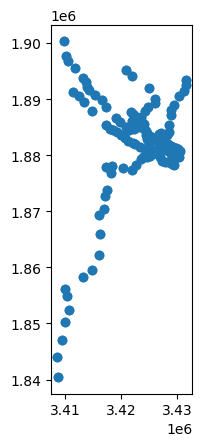

In [29]:
nodes = gpd.GeoDataFrame(nodes, geometry='geometry', crs='EPSG:3035')
nodes.plot()

## Map trips to stops

In [30]:
trips_to_stops = stop_times.groupby('trip_id')['stop_id'].apply(lambda x: [str(stop_id) for stop_id in x])
trips_to_stops

trip_id
4118017    [30, 31, 32, 33, 50, 49, 48, 47, 46, 45, 44, 4...
4118018    [55, 54, 53, 52, 17, 51, 25, 26, 27, 28, 30, 3...
4118019                                     [30, 31, 32, 33]
4118020    [107, 80, 79, 78, 77, 76, 75, 74, 73, 72, 55, ...
4118021    [107, 80, 79, 78, 77, 76, 75, 74, 73, 72, 55, ...
                                 ...                        
4436367             [197, 196, 195, 194, 193, 192, 191, 190]
4436368             [197, 196, 195, 194, 193, 192, 191, 190]
4436369             [197, 196, 195, 194, 193, 192, 191, 190]
4436370             [197, 196, 195, 194, 193, 192, 191, 190]
4436371             [197, 196, 195, 194, 193, 192, 191, 190]
Name: stop_id, Length: 11651, dtype: object

In [31]:
trips_to_stops_exploded = trips_to_stops.explode()
trips_to_stops_exploded

trip_id
4118017     30
4118017     31
4118017     32
4118017     33
4118017     50
          ... 
4436371    194
4436371    193
4436371    192
4436371    191
4436371    190
Name: stop_id, Length: 204052, dtype: object

## Create edges

Edges are created from trips and trip-to-stop mapping 

In [32]:
edges_original = trips_to_stops_exploded.copy().to_frame()

In [33]:
edges_original.loc[:, 'destination'] = edges_original.groupby('trip_id')['stop_id'].shift(-1)
edges_original = edges_original.rename(columns={'stop_id':'origin'})
edges_original = edges_original.dropna()
edges_original = edges_original.reset_index(drop=True)
edges_original = edges_original.drop_duplicates()
edges_original.head()

,origin,destination
0,30,31
1,31,32
2,32,33
3,33,50
4,50,49


In [34]:
# add artificial links ... -> ...X

origins = nodes_original['node_id']
destinations = nodes_extra['node_id']

edges_to_add = pd.concat([origins, destinations], axis='columns', ignore_index=True)
edges_to_add.columns = ['origin', 'destination']
edges_to_add.head()

,origin,destination
0,30,30X
1,31,31X
2,32,32X
3,33,33X
4,50,50X


In [35]:
# change origin nodex to ...X nodes
edges = edges_original.copy()
edges['origin'] = edges['origin'] + 'X'

In [36]:
edges = pd.concat([edges, edges_to_add], axis='index', ignore_index=True).reset_index(drop=True)
edges.shape

(428, 2)

In [37]:
# get stop coordinates 
edges = pd.merge(edges, nodes.loc[:, ['node_id', 'geometry']], left_on='origin', right_on='node_id', how='left').rename(columns={'geometry':'geometry_origin'}).drop(columns='node_id')
edges = pd.merge(edges, nodes.loc[:, ['node_id', 'geometry']], left_on='destination', right_on='node_id').rename(columns={'geometry':'geometry_destination'}).drop(columns='node_id')
edges

,origin,destination,geometry_origin,geometry_destination
0,30X,31,POINT (3422756.836 1878262.325),POINT (3422004.317 1877412.428)
1,31X,32,POINT (3422004.317 1877412.428),POINT (3420379.838 1877732.532)
2,32X,33,POINT (3420379.838 1877732.532),POINT (3418359.386 1878182.392)
3,33X,50,POINT (3418359.386 1878182.392),POINT (3418229.276 1876915.952)
4,50X,49,POINT (3418229.276 1876915.952),POINT (3417538.438 1873750.785)
...,...,...,...,...
423,194,194X,POINT (3427838.185 1878877.847),POINT (3427838.185 1878877.847)
424,195,195X,POINT (3428333.846 1878748.108),POINT (3428333.846 1878748.108)
425,196,196X,POINT (3429073.501 1878436.199),POINT (3429073.501 1878436.199)
426,197,197X,POINT (3429389.853 1878363.781),POINT (3429389.853 1878363.781)


In [38]:
edges.loc[:, 'geometry'] = edges.apply(lambda row: LineString((row['geometry_origin'], row['geometry_destination'])), axis='columns')
edges = edges.drop(columns=['geometry_origin', 'geometry_destination'])
edges

,origin,destination,geometry
0,30X,31,LINESTRING (3422756.836054841 1878262.32500610...
1,31X,32,LINESTRING (3422004.3166353386 1877412.4276033...
2,32X,33,LINESTRING (3420379.8380653625 1877732.5319231...
3,33X,50,LINESTRING (3418359.385911867 1878182.39183645...
4,50X,49,LINESTRING (3418229.2762813093 1876915.9523594...
...,...,...,...
423,194,194X,LINESTRING (3427838.1850216384 1878877.8470491...
424,195,195X,LINESTRING (3428333.8461786644 1878748.1082145...
425,196,196X,LINESTRING (3429073.5011933106 1878436.1985312...
426,197,197X,LINESTRING (3429389.8530499344 1878363.7812761...


In [39]:
edges = gpd.GeoDataFrame(edges, geometry='geometry', crs='EPSG:3035')

In [40]:
edges['length'] = edges['geometry'].length
edges['edge_id'] = edges['origin'].astype('str') + '_' + edges['destination'].astype('str')

<Axes: >

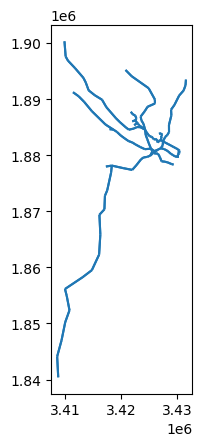

In [41]:
edges.plot()

In [42]:
edges.dtypes

origin           object
destination      object
geometry       geometry
length          float64
edge_id          object
dtype: object

## Network to XML (`network.xml`)

In [43]:
version = 1
graph_to_load = 'v' + str(version)

In [44]:
root = etree.Element('network', name=f'{gtfs_name}_network_' + graph_to_load)

## GENERATING NODES

nodes_item = etree.SubElement(root, 'nodes')

for _, node in nodes.iterrows():
    
    nodes_item.append(etree.Element('node',
                                    id=str(node['node_id']), 
                                    x=str(node['geometry'].coords.xy[0][0]), 
                                    y=str(node['geometry'].coords.xy[1][0])))

## GENERATING LINKS

links_item = etree.SubElement(root, 'links')

for _, link in edges.iterrows():

    from_node = str(link['origin'])
    to_node = str(link['destination'])
    
    link_item = etree.SubElement(links_item, 'link')

    link_item.set('id', link['edge_id'])
    link_item.set('from', str(from_node))
    link_item.set('to', str(to_node))
    link_item.set('freespeed', str(10))
    link_item.set('capacity', str(100))
    link_item.set('permlanes', str(1))
    link_item.set('length', str(link['length']))
    link_item.set('modes', 'pt')

doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v1.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

if not os.path.exists(os.path.join(os.getcwd(), f'networks_emt_v{version}')):
    os.mkdir(f'networks_emt_v{version}')
    
with open(f'networks_metrovalencia_v{version}/network_' + graph_to_load + '.xml', 'wb') as file:
    file.write(final_xml)

## Input date

The date introduced is used to generate transit schedules for this day in particular.

`calendat.txt` and `calendar_dates.txt` are checked to filter the schedule.

In [65]:
calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,2502,0,0,0,0,0,0,0,2024-12-06,2024-12-06
1,2516,0,0,0,0,0,0,0,2024-09-02,2024-12-31
2,2662,0,0,0,0,0,0,0,2024-09-06,2024-12-27
3,2663,0,0,0,0,0,0,0,2024-08-03,2024-08-31
4,2665,0,0,0,0,0,0,0,2024-10-25,2024-10-25
5,2667,0,0,0,0,0,0,0,2024-10-26,2024-10-26
6,2695,0,0,0,0,0,0,0,2024-10-12,2024-10-12
7,2748,0,0,0,0,0,0,0,2024-10-27,2024-10-27


In [58]:
date_to_check = pd.to_datetime('2024-10-29')

weekday_names = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

In [66]:
# OVERRIDE has_calendar PARAM BECAUSE calendar IS FILLED WITH ZEROS
has_calendar = False

In [67]:
print(f'calendar.txt is{'not' * (not has_calendar)} available.' )
print(f'calendar_dates.txt is{'not' * (not has_calendar_dates)} available.' )

# if we have both files
if has_calendar & has_calendar_dates:
    
    # CHECK CALENDAR
    # define conditions to filter calendars 
    condition_date_range = calendar['start_date'].le(date_to_check) & calendar['end_date'].ge(date_to_check)
    condition_weekday = calendar[weekday_names[date_to_check.weekday()]].eq(1)
    
    # preliminarly filter by conditions
    relevant_service_ids = calendar.loc[condition_date_range & condition_weekday, 'service_id']
    print(relevant_service_ids)
    
    # CHECK CALENDAR DATES
    if relevant_service_ids.shape[0] > 0:
        if date_to_check in calendar_dates['date'].values:
            service_ids_to_add = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), 'service_id']
            service_ids_to_delete = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(2), 'service_id']
            
            # adding service ids
            relevant_service_ids = pd.concat([relevant_service_ids, calendar.loc[condition_date_range & calendar['service_id'].isin(service_ids_to_add), :]], axis='index')
            print(f'Added: {service_ids_to_add}')
            
            # removing service ids
            relevant_service_ids_merged = pd.merge(relevant_service_ids, calendar.loc[condition_date_range & calendar['service_id'].isin(service_ids_to_delete), :], how='left', indicator=True)
            relevant_service_ids = relevant_service_ids_merged.loc[relevant_service_ids_merged['_merge'].ne('both')].drop(columns='_merge')
            print(f'Deleted: {service_ids_to_delete}')
        else:
            print('No changes were made to the candidate list.')
    else:
        if date_to_check in calendar_dates['date'].values:
            if calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), :].shape[0] > 0:
                pass # add exception
        else:
            print('No service_id found for this date.')
# if we have calendar only
elif has_calendar & (not has_calendar_dates):
    # define conditions to filter calendars 
    condition_date_range = calendar['start_date'].le(date_to_check) & calendar['end_date'].ge(date_to_check)
    condition_weekday = calendar[weekday_names[date_to_check.weekday()]].eq(1)
    
    # preliminarly filter by conditions
    relevant_service_ids = calendar.loc[condition_date_range & condition_weekday]
# if we have calendar_dates only
else:
    relevant_service_ids = []
    
    if date_to_check in calendar_dates['date'].values:
        service_ids_to_add = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), 'service_id']
        
        # adding service ids
        relevant_service_ids = service_ids_to_add
        print(f'Added: {service_ids_to_add}')


calendar.txt isnot available.
calendar_dates.txt is available.
Added: 32    2516
Name: service_id, dtype: int64


In [69]:
relevant_service_ids

32    2516
Name: service_id, dtype: int64

## Map links to routes

In [70]:
# create artificial links sequence
route_links_extra = trips_to_stops_exploded.copy().to_frame()
route_links_extra['stop_id'] = route_links_extra['stop_id'] + 'X'

route_links_extra = pd.concat([trips_to_stops_exploded.copy().to_frame(), route_links_extra], axis='columns')
route_links_extra.columns = ['origin', 'destination']
route_links_extra = route_links_extra.reset_index()
route_links_extra.head()

,trip_id,origin,destination
0,4118017,30,30X
1,4118017,31,31X
2,4118017,32,32X
3,4118017,33,33X
4,4118017,50,50X


In [71]:
# create real links sequence
route_links_original = route_links_extra.copy()

route_links_original.loc[:, 'origin_shifted'] = route_links_original.groupby('trip_id')['origin'].shift(-1)
route_links_original = route_links_original.drop(columns=['origin'])
route_links_original = route_links_original.dropna()
route_links_original.columns = ['trip_id', 'origin', 'destination']
route_links_original

,trip_id,origin,destination
0,4118017,30X,31
1,4118017,31X,32
2,4118017,32X,33
3,4118017,33X,50
4,4118017,50X,49
...,...,...,...
204046,4436371,195X,194
204047,4436371,194X,193
204048,4436371,193X,192
204049,4436371,192X,191


In [72]:
route_links = pd.concat([route_links_extra, 
           route_links_original], axis='index', ignore_index=False).reset_index().sort_values(by=['index', 'origin'])
route_links

,index,trip_id,origin,destination
0,0,4118017,30,30X
204052,0,4118017,30X,31
1,1,4118017,31,31X
204053,1,4118017,31X,32
2,2,4118017,32,32X
...,...,...,...,...
204049,204049,4436371,192,192X
396451,204049,4436371,192X,191
204050,204050,4436371,191,191X
396452,204050,4436371,191X,190


## To XML (transitSchedule.xml)

In [73]:
trips_filtered = trips.loc[trips['service_id'].isin(relevant_service_ids), :]
routes_filtered = routes.loc[routes['route_id'].isin(trips_filtered['route_id'].unique())]

trips.shape, trips_filtered.shape, routes.shape, routes_filtered.shape

((11651, 5), (1718, 5), (120, 7), (97, 7))

In [74]:
vehicle_counter = 0

In [75]:
root = etree.Element('transitSchedule')


transit_stops_item = etree.SubElement(root, 'transitStops')

# STOP FACILITIES from original stops
for _, stop_facility in nodes_original.iterrows():
    
    stop_facility_id = stop_facility['node_id']

    transit_stops_item.append(etree.Element('stopFacility', 
                                            id=stop_facility_id, 
                                            x=str(stop_facility['geometry'].coords.xy[0][0]), 
                                            y=str(stop_facility['geometry'].coords.xy[1][0]),
                                            linkRefId=f'{stop_facility_id}_{stop_facility_id}X'
                                            ))
    
# TRANSIT LINES from routes
for _, route in routes_filtered.iterrows():
    
    transit_line_item = etree.SubElement(root, 'transitLine', 
                                          id=str(route['route_id']),
                                          name=str(route['route_short_name']))
    
    # TRANSIT ROUTE
    # filtering trips (transitRoute) for this route (transitLine) only
    trips_filtered_again = trips_filtered.loc[trips_filtered['route_id'].eq(route['route_id']),:]
    
    for _, trip in trips_filtered_again.iterrows():
        
        transit_route_item = etree.SubElement(transit_line_item, 'transitRoute', 
                                              id=str(trip['trip_id']))
        
        # TRANSIT MODE
        transit_mode_item = etree.SubElement(transit_route_item, 'transportMode')
        transit_mode_item.text = "pt"
    
        routes_profile_item = etree.SubElement(transit_route_item, 'routeProfile')
        
        # ROUTE PROFILE
        # filtering stop_times for the current trip only
        stop_times_filtered = stop_times_merged.loc[stop_times_merged['trip_id'].eq(trip['trip_id']),:]
        
        is_first_stop = True
        last_stop_index = stop_times_filtered.tail(1).index
        for _, stop_time in stop_times_filtered.iterrows():
            
            stop_id = str(stop_time['stop_id'])
            
            if is_first_stop:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     departureOffset=str(stop_time['departure_time_offset_str']),
                                                     awaitDeparture="true"
                                                     # arrivalOffset=str(stop_time['arrival_time_offset_str'])
                                                         ))
                is_first_stop = False
            elif _ == last_stop_index:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     # departureOffset=str(stop_time['departure_time_offset_str']),
                                                     arrivalOffset=str(stop_time['arrival_time_offset_str']),
                                                     awaitDeparture="true"
                                                     ))
            else:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     arrivalOffset=str(stop_time['arrival_time_offset_str']),
                                                     departureOffset=str(stop_time['departure_time_offset_str']),
                                                     awaitDeparture="true"
                                                     ))

        # ROUTE (all the links for a specific route, not only the ones with stops)
        route_item = etree.SubElement(transit_route_item, 'route')
        
        route_links_filtered = route_links.loc[route_links['trip_id'].eq(trip['trip_id']), :]
        # print(route_links_filtered.shape)
        
        for _, route_link in route_links_filtered.iterrows():
            route_item.append(etree.Element('link', 
                                            refId=f'{route_link['origin']}_{route_link['destination']}'))
        
        # DEPARTURES
        departures_item = etree.SubElement(transit_route_item, 'departures')
        
        if has_frequencies:
            # if there is a frequency for a trip, ...
            if trip['trip_id'] in frequencies['trip_id'].values:
                # print(f'Trip {trip['trip_id']} has a frequency')
                # ...generate a departure for every frequency
                
                # filtering frequencies for the current trip only
                frequencies_filtered = frequencies.loc[frequencies['trip_id'].eq(trip['trip_id']),:]
                
                for _, frequency in frequencies_filtered.iterrows(): # in every frequency there is an interval with it's frequency in seconds 
                    departures = pd.timedelta_range(start=frequency['start_time'], 
                                                    end=frequency['end_time'], 
                                                    freq=str(frequency['headway_secs']) + 's', 
                                                    closed='left')
                    
                    for departure_index, departure in enumerate(departures):
                        vehicle_counter = vehicle_counter + 1
    
                        vehicleRefId = 'veh_' + str(vehicle_counter)
    
                        departures_item.append(etree.Element('departure', 
                                                             id=str(_) + '_' + str(departure_index),
                                                             departureTime=timedelta_to_str(departure),
                                                             vehicleRefId=vehicleRefId
                                                             ))
            # if there is no frequency for a trip, ...
            else:
                vehicle_counter = vehicle_counter + 1
                
                vehicleRefId = 'veh_' + str(vehicle_counter)
    
                # ...generate only one departure from stop_times_departures
                single_departure = stop_times_filtered.loc[stop_times_filtered['trip_id'].eq(trip['trip_id']),'departure_time_original'].iloc[0]
                departures_item.append(etree.Element('departure', 
                                                         id=str(_),
                                                         departureTime=timedelta_to_str(single_departure),
                                                         vehicleRefId=vehicleRefId
                                                     ))
        else:
            vehicle_counter = vehicle_counter + 1
            
            vehicleRefId = 'veh_' + str(vehicle_counter)

            # ...generate only one departure from stop_times_departures
            single_departure = stop_times_filtered.loc[stop_times_filtered['trip_id'].eq(trip['trip_id']),'departure_time_original'].iloc[0]
            departures_item.append(etree.Element('departure', 
                                                     id=str(_),
                                                     departureTime=timedelta_to_str(single_departure),
                                                     vehicleRefId=vehicleRefId
                                                 ))

doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE transitSchedule SYSTEM "http://www.matsim.org/files/dtd/transitSchedule_v1.dtd">\n'

final_xml = etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)
    
with open(f'networks_metrovalencia_v{version}/transitSchedule.xml', 'wb') as file:
    file.write(final_xml)

## To XML (transitVehicles.xml)

In [76]:
vehicle_ids = np.arange(1, vehicle_counter + 1)
vehicle_ids

array([   1,    2,    3, ..., 1716, 1717, 1718])

In [78]:
from lxml import etree

# Namespace and schema locations
namespace = "http://www.matsim.org/files/dtd"
schema_location = "http://www.matsim.org/files/dtd/vehicleDefinitions_v1.0.xsd"

# Namespace map
nsmap = {
    None: namespace,  # Default namespace
    "xsi": "http://www.w3.org/2001/XMLSchema-instance"
}

# Root element with namespaces
root = etree.Element("vehicleDefinitions", nsmap=nsmap)
root.set(etree.QName(nsmap["xsi"], "schemaLocation"), f"{namespace} {schema_location}")

# Vehicle type definition
vehicle_type = etree.SubElement(root, "vehicleType", id="bus")

description = etree.SubElement(vehicle_type, "description")
description.text = "Ordinary Bus"

capacity = etree.SubElement(vehicle_type, "capacity")
seats = etree.SubElement(capacity, "seats", persons="50")
standing = etree.SubElement(capacity, "standingRoom", persons="30")

length = etree.SubElement(vehicle_type, "length", meter="25.0")

# Adding vehicles
for vehicle_id in vehicle_ids:
    etree.SubElement(root, "vehicle", id='veh_' + str(vehicle_id), type='bus')

# Convert to pretty-printed XML string
xml_str = etree.tostring(root, pretty_print=True, xml_declaration=True, encoding='UTF-8')

# Save to file or print
with open(f'networks_metrovalencia_v{version}/vehicleDefinitions.xml', "wb") as f:
    f.write(xml_str)

## Create sample population

In [79]:
columns_to_keep = [
 'Codigo',
 # 'Denominacion_Generica_ES',
 # 'Denominacion_Generica_VAL',
 # 'Denominacion_Especifica',
 'Denominacion',
 'Regimen',
 # 'Tipo_Via',
 'Direccion',
#  'Num',
 'Codigo_postal',
 'Localidad',
 'Provincia',
 'Telefono',
 # 'Fax',
 # 'COD_EDIFICACION', # solo tiene un valor de 1
 'long',
 'lat',
 'Titularidad',
#  'CIF',
 'Comarca',
]

centros = pd.read_excel('data/centros_docentes_12-11-2024.xls',
                        usecols=columns_to_keep)
centros

WARNING *** file size (2743830) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Codigo,Denominacion,Regimen,Direccion,Codigo_postal,Localidad,Provincia,Telefono,long,lat,Titularidad,Comarca
0,3001829,CENTRE PRIVAT MÉDICO PEDRO HERRERO,Priv. Conc.,VICTOR DE LA SERNA,3006,ALACANT,Alacant,965102455,-0.515928,38.349410,NaN,L'ALACANTÍ
1,3001854,CEIP ÓSCAR ESPLÁ,Púb.,DE LA LIBERTAD,3010,ALACANT,Alacant,965937105,-0.493805,38.365862,GENERALITAT VALENCIANA,L'ALACANTÍ
2,3001881,IES JORGE JUAN,Púb.,WENCESLAO FERNÁNDEZ FLORES,3004,ALACANT,Alacant,965936490,-0.493033,38.349339,GENERALITAT VALENCIANA,L'ALACANTÍ
3,3001891,IES MIGUEL HERNÁNDEZ,Púb.,POETA GARCILASO,3005,ALACANT,Alacant,965936545,-0.495388,38.350607,GENERALITAT VALENCIANA,L'ALACANTÍ
4,3001908,IES FIGUERAS PACHECO,Púb.,FERNANDO MADROÑAL,3007,ALACANT,Alacant,965936495,-0.511393,38.340419,GENERALITAT VALENCIANA,L'ALACANTÍ
...,...,...,...,...,...,...,...,...,...,...,...,...
3702,46037595,ESCOLA PÚBLICA DÀRTS ESCÈNIQUES EMT,Púb.,PERE EL GRAN,46460,SILLA,València,NaN,-0.410963,39.367708,AJUNTAMENT SILLA,L'HORTA SUD
3703,46037601,EI 1er CICLO,Púb.,SAN JUAN,46177,TUÉJAR,València,NaN,-1.042304,39.766940,GENERALITAT VALENCIANA,LA SERRANÍA
3704,46037650,CENTRE PRIVAT FP CEAC,Priv.,DE LA ILUSTRACIÓN,46100,BURJASSOT,València,963106810,0.000000,0.000000,NaN,L'HORTA NORD
3705,46037674,CENTRE PRIV. ED. INF. 1er CICLE EL PATI,Priv.,SANT JOAN,46530,PUÇOL,València,679609380,-0.301047,39.616454,NaN,L'HORTA NORD


In [80]:
centros['geometry'] = centros.apply(lambda row: Point(row.long, row.lat), axis=1)
centros['geometry'].head()

0     POINT (-0.515928 38.34941)
1    POINT (-0.493805 38.365862)
2    POINT (-0.493033 38.349339)
3    POINT (-0.495388 38.350607)
4    POINT (-0.511393 38.340419)
Name: geometry, dtype: object

In [81]:
centros_gdf = gpd.GeoDataFrame(centros, geometry='geometry', crs='EPSG:4326')

In [82]:
centros_gdf = centros_gdf.to_crs('EPSG:3035')
centros_gdf

,Codigo,Denominacion,Regimen,Direccion,Codigo_postal,Localidad,Provincia,Telefono,long,lat,Titularidad,Comarca,geometry
0,3001829,CENTRE PRIVAT MÉDICO PEDRO HERRERO,Priv. Conc.,VICTOR DE LA SERNA,3006,ALACANT,Alacant,965102455,-0.515928,38.349410,NaN,L'ALACANTÍ,POINT (3398723.386 1759899.894)
1,3001854,CEIP ÓSCAR ESPLÁ,Púb.,DE LA LIBERTAD,3010,ALACANT,Alacant,965937105,-0.493805,38.365862,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3400874.117 1761435.039)
2,3001881,IES JORGE JUAN,Púb.,WENCESLAO FERNÁNDEZ FLORES,3004,ALACANT,Alacant,965936490,-0.493033,38.349339,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3400716.13 1759615.808)
3,3001891,IES MIGUEL HERNÁNDEZ,Púb.,POETA GARCILASO,3005,ALACANT,Alacant,965936545,-0.495388,38.350607,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3400528.335 1759783.096)
4,3001908,IES FIGUERAS PACHECO,Púb.,FERNANDO MADROÑAL,3007,ALACANT,Alacant,965936495,-0.511393,38.340419,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3398995.555 1758860.278)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3702,46037595,ESCOLA PÚBLICA DÀRTS ESCÈNIQUES EMT,Púb.,PERE EL GRAN,46460,SILLA,València,NaN,-0.410963,39.367708,AJUNTAMENT SILLA,L'HORTA SUD,POINT (3421727.378 1870249.287)
3703,46037601,EI 1er CICLO,Púb.,SAN JUAN,46177,TUÉJAR,València,NaN,-1.042304,39.766940,GENERALITAT VALENCIANA,LA SERRANÍA,POINT (3373431.071 1921691.313)
3704,46037650,CENTRE PRIVAT FP CEAC,Priv.,DE LA ILUSTRACIÓN,46100,BURJASSOT,València,963106810,0.000000,0.000000,NaN,L'HORTA NORD,POINT (3086656.975 -2292253.812)
3705,46037674,CENTRE PRIV. ED. INF. 1er CICLE EL PATI,Priv.,SANT JOAN,46530,PUÇOL,València,679609380,-0.301047,39.616454,NaN,L'HORTA NORD,POINT (3434534.679 1896241.002)


In [83]:
centros_vlc = centros_gdf.loc[centros_gdf['Provincia'].eq('València') & centros_gdf['Localidad'].eq('VALÈNCIA')]
centros_vlc

,Codigo,Denominacion,Regimen,Direccion,Codigo_postal,Localidad,Provincia,Telefono,long,lat,Titularidad,Comarca,geometry
2047,46009150,CENTRE PRIVAT NUESTRA SEÑORA DEL ROSARIO,Priv. Conc.,FORTUNA,46026,VALÈNCIA,València,963960743,-0.364987,39.428261,NaN,VALÈNCIA,POINT (3426497.481 1876347.715)
2049,46009368,CENTRE PRIVAT MARTÍ SOROLLA,Priv. Conc.,RIU ERESMA,46026,VALÈNCIA,València,963730103,-0.375166,39.451699,NaN,VALÈNCIA,POINT (3425945.606 1879038.009)
2050,46009371,CENTRE PRIVAT ESCUELAS PÍAS,Priv. Conc.,CARNICEROS,46001,VALÈNCIA,València,963915800,-0.382322,39.474018,NaN,VALÈNCIA,POINT (3425638.028 1881570.082)
2051,46009460,CENTRE PRIVAT SAGRADO CORAZÓN DE JESÚS -CARMEL...,Priv. Conc.,MURO SANTA ANA,46003,VALÈNCIA,València,963910512,-0.374898,39.478871,NaN,VALÈNCIA,POINT (3426340.162 1882014.945)
2052,46009472,CENTRE PRIVAT GRAN ASOCIACIÓN,Priv. Conc.,PADRE HUÉRFANOS,46003,VALÈNCIA,València,963911791,-0.377980,39.479735,NaN,VALÈNCIA,POINT (3426088.074 1882145.977)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692,46037431,CENTRE PRIVAT FP VERGE DE CORTES. PATRAIX,Priv.,URUGUAY,46007,VALÈNCIA,València,655697737,-0.385511,39.460238,NaN,VALÈNCIA,POINT (3425176.291 1880096.337)
3697,46037522,E. PRIV. D'ARTS ESC. CREAT FORM. Y CREA. EN AR...,Priv.,VICENTE CANET,46025,VALÈNCIA,València,NaN,-0.391862,39.500960,NaN,VALÈNCIA,POINT (3425190.242 1884637.341)
3698,46037534,ESCOLA PRIVADA D'ARTS ESCÈNIQUES ELEDANCE ACAD...,Priv.,FELIPE VALLS,46035,VALÈNCIA,València,NaN,-0.420842,39.504882,NaN,VALÈNCIA,POINT (3422763.598 1885409.429)
3699,46037546,ESCOLA PRIVADA D'ARTS ESCEÈNIQUES SARGANTANA C...,Priv.,VIRGEN DE LA CABEZA,46014,VALÈNCIA,València,NaN,-0.397234,39.460262,NaN,VALÈNCIA,POINT (3424172.531 1880237.163)


In [84]:
sample_population = pd.merge(centros_vlc.loc[:, ['Codigo', 'geometry']],
         centros_vlc.loc[:, ['Codigo', 'geometry']], how='cross', suffixes=['_origin', '_destination']).sample(100)

sample_population

,Codigo_origin,geometry_origin,Codigo_destination,geometry_destination
66074,46013517,POINT (3426705.801 1878130.439),46011612,POINT (3427920.049 1879759.9)
134994,46024242,POINT (3426607.079 1880025.075),46010735,POINT (3426419.724 1882754.118)
212496,46034363,POINT (3425439.554 1880690.978),46024072,POINT (3423551.902 1879333.684)
220504,46035847,POINT (3429307.942 1880906.399),46036062,POINT (3426885.478 1883956.187)
95387,46018552,POINT (3428960.259 1879451.705),46010772,POINT (3424733.496 1880391.865)
...,...,...,...,...
23053,46011181,POINT (3428068.881 1882656.989),46011922,POINT (3423159.27 1880869.548)
217866,46035379,POINT (3424158.34 1880152.882),46023493,POINT (3424824.675 1883908.294)
83185,46016968,POINT (3425459.208 1881300.052),46011511,POINT (3428687.118 1880045.068)
72143,46015231,POINT (3424199.728 1883535.292),46023444,POINT (3424872.586 1879346.851)


In [85]:
sample_population['hour'] = pd.Series([np.random.uniform(4,9) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population['minute'] = pd.Series([np.random.uniform(0,60) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population['second'] = pd.Series([np.random.uniform(0,60) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population

,Codigo_origin,geometry_origin,Codigo_destination,geometry_destination,hour,minute,second
66074,46013517,POINT (3426705.801 1878130.439),46011612,POINT (3427920.049 1879759.9),6,39,42
134994,46024242,POINT (3426607.079 1880025.075),46010735,POINT (3426419.724 1882754.118),4,52,34
212496,46034363,POINT (3425439.554 1880690.978),46024072,POINT (3423551.902 1879333.684),8,7,29
220504,46035847,POINT (3429307.942 1880906.399),46036062,POINT (3426885.478 1883956.187),7,34,14
95387,46018552,POINT (3428960.259 1879451.705),46010772,POINT (3424733.496 1880391.865),4,53,6
...,...,...,...,...,...,...,...
23053,46011181,POINT (3428068.881 1882656.989),46011922,POINT (3423159.27 1880869.548),8,43,14
217866,46035379,POINT (3424158.34 1880152.882),46023493,POINT (3424824.675 1883908.294),5,41,16
83185,46016968,POINT (3425459.208 1881300.052),46011511,POINT (3428687.118 1880045.068),6,37,19
72143,46015231,POINT (3424199.728 1883535.292),46023444,POINT (3424872.586 1879346.851),5,21,28


## To XML (population.xml)

In [86]:
root = etree.Element('plans')

for _, person in sample_population.iterrows():
    person_item = etree.SubElement(root, 'person')
    person_item.set('id', str(_))

    plan_item = etree.SubElement(person_item, 'plan')
    plan_item.set('selected', 'yes')

    
    origin_latitude = person['geometry_origin'].coords.xy[1][0]
    origin_longitude = person['geometry_origin'].coords.xy[0][0]
    destination_latitude = person['geometry_destination'].coords.xy[1][0]
    destination_longitude = person['geometry_destination'].coords.xy[0][0]
    
    origin_end_time = str(time(person['hour'], person['minute'], person['second']))
    destination_end_time = str(time(23,59,59))

    act_item_origin = etree.SubElement(plan_item, 'act')
    act_item_origin.set('type', 'h')
    act_item_origin.set('x', str(origin_longitude))
    act_item_origin.set('y', str(origin_latitude))
    act_item_origin.set('end_time', origin_end_time)

    leg_item = etree.SubElement(plan_item, 'leg')
    leg_item.set('mode', 'pt')

    act_item_destination = etree.SubElement(plan_item, 'act')
    act_item_destination.set('type', 'w')
    act_item_destination.set('x', str(destination_longitude))
    act_item_destination.set('y', str(destination_latitude))
    # act_item_destination.set('end_time', destination_end_time)


doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE plans SYSTEM "http://www.matsim.org/files/dtd/plans_v4.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

with open(f'networks_metrovalencia_v{version}/population100.xml', 'wb') as file:
    file.write(final_xml)